In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pickle import load, dump
import warnings
import os
from random import sample
import imageio
import numpy as np

warnings.filterwarnings("ignore")

#path = "C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
path = os.getcwd()
cd = 0.041
cw = 0.0388

In [2]:
stations = pd.read_csv(path+"/Data/Definite Stations.csv",index_col=[0])
vehicles = pd.read_csv(path+"/Data/Definite Vehicles.csv",index_col=[0])
locations = pd.read_csv(path+"/Data/Definite Locations.csv",index_col=[0])

In [3]:
file = open(path+"/Multiobjective/Configurations/Open Stations/open_stations_0.0","rb")
open_stats = load(file); file.close()

file = open(path+"/Multiobjective/Configurations/Stress Index/stress_index_0.0","rb")
stress_index = load(file); file.close()

file = open(path+"/Results/Optimal/S","rb")
S = load(file); file.close()

file = open(path+"/Results/Optimal/results","rb")
results = load(file); file.close()

file = open(path+"/Results/Optimal/n","rb")
n = load(file); file.close()

file = open(path+"/Results/Optimal/order","rb")
stats_order = load(file); file.close()


K = {}; S_k = {}
for sc in range(25):
    file = open(path+f"/Data/K/K_sc{sc}","rb")
    K[sc] = load(file); file.close()

    file = open(path+f"/Data/S_k10/Sk_sc{sc}","rb")
    S_k[sc] = load(file); file.close()


S_k = {sc:{k:[s for s in S_k[sc][k] if s in open_stats] for k in K[sc]} for sc in range(25)}
max_stress = max([stress_index[sc][s] for sc in range(sc) for s in open_stats]); min_stress = 0

In [4]:
def plot_solution(station,chargers,locations,stress_index,routes,prev_stats,sc=5):
    
    ''' Update stress indices and location bubble sizes '''
    if chargers > 0:
        for ssc in range(25):
            for i in routes[ssc][station][chargers-1]:
                for s in S_k[ssc][i]:
                    stress_index[ssc][s] -= 1
                if ssc == sc:
                    coord = i - int(i/1079)*1079
                    locations.loc[coord,f"going {sc}"] -= 1

    ''' Create plot '''
    img = plt.imread(path+"/Problem Visualization/Population grey.PNG")
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))
    plt.ioff()
    
    ''' Vehicles '''
    locs = [l for l in locations.index if locations.loc[l,f"going {sc}"]>0]
    szs = [15+25*locations.loc[l,f"going {sc}"] for l in locs]
    ax.scatter(locations["0"][locs],locations["1"][locs],s=szs,color="navy",alpha=0.5)

    ''' Vehicle bubbles legend '''
    szs = {10:144.2, 9:138.4, 8:133, 7:127.8, 6:122.9, 5:118.5, 4:114.5, 3:110.8, 2:107.65, 1:105}
    for l in range(1,11):
        ax.scatter([-25],[szs[l]],marker="o",s=15+25*l,color="navy",alpha=0.5)
        if l in [1,10]:
            ax.text(x=-20,y=szs[l],s=l,va="center",ha="left",fontsize=14)
    ax.text(x=-32,y=126,rotation=90,s="vehicles per location", fontsize=14, va="center", ha="center", fontname="Century Gothic")
    
    ''' Color map legend '''
    cm = plt.get_cmap("gist_heat")
    for i in range(401):
        ax.bar(x=-25,height=0.1875,width=5,bottom=10.5+0.1875*i,color=cm((1-i/400)*0.9))
    for i in range(6):
        ax.text(x=-20,y=10.5+75*i/5,s=int((max_stress-min_stress)*i/5),va="center",ha="left",fontsize=14)
    ax.text(x=-32,y=48,rotation=90,s="stations stress index", fontsize = 14, va="center",ha="center", fontname="Century Gothic")
    
    ''' Stations Plot '''
    stats = [s for s in open_stats if (s not in prev_stats) and (chargers == 0 or (s != station))]
    cols = [cm((1-stress_index[sc][s]/max_stress)*0.9) for s in stats]
    ax.scatter(stations["0"][stats],stations["1"][stats],c=cols)

    ''' Previous Stations '''
    for s in prev_stats:
        ax.plot(stations.loc[s,"0"],stations.loc[s,"1"],marker="D",color="lime",markersize=10+1*(n[s]-1),alpha=0.7)

    ''' Current Station '''
    if chargers == 0:
        ax.plot(stations.loc[station,"0"],stations.loc[station,"1"],marker="D",markeredgewidth=2,markeredgecolor="lime",markerfacecolor="None",markersize=10)
    else:
        ax.plot(stations.loc[station,"0"],stations.loc[station,"1"],marker="D",color="lime",markersize=10+1*(chargers-1),alpha=0.7)
    
    ''' Current Station legend '''
    szs = {8:150.6, 7:141.8, 6:133.6, 5:125.8, 4:118.6, 3:111.9, 2:105.78, 1:100.1}
    for ch in range(1,9):
        if ch <= chargers: col = "lime"
        else: col = "grey"
        ax.plot(szs[ch],-17.5,marker="D",markersize=10+1*(ch-1),color=col,alpha=0.7)
    ax.text(x=125,y=-25,s="number of chargers",va="center",ha="center",fontsize=14,fontname="Century Gothic")
    if chargers == n[station]: col = "lime"
    else: col = "black"
    ax.text(x=70,y=-20,s=f"Current station\nID: {station}",va="center",ha="center",color=col,fontsize=16,fontname="Century Gothic")

    exp_stress = round(np.mean([stress_index[ssc][station] for ssc in range(25)]),2)
    if exp_stress == 0.0: col = "lime"
    elif chargers == n[station]: col = "red"
    else: col = "black"
    ax.text(x=160,y=-15,s=f"Expected Stress Index: {exp_stress}",fontsize=14,fontname="Century Gothic",va="center",ha="left",color=col)
    if stress_index[sc][station] == 0: col = "lime"
    elif chargers == n[station]: col = "red"
    else: col = "black"
    ax.text(x=160,y=-25,s=f"This scenario: {int(stress_index[sc][station])}",fontsize=14,fontname="Century Gothic",va="center",ha="left",color=col)

    ''' Map border '''
    ax.vlines(x=[0,290],ymin=0,ymax=150,color="black")
    ax.hlines(y=[0,150],xmin=0,xmax=290,color="black")
    ax.spines[["top","bottom","left","right"]].set_visible(False)

    ''' Ax config '''
    zero = (-5,-12)
    height = 184.425
    ax.imshow(img, extent=[zero[0], zero[0]+height*5/3, zero[1], zero[1]+height])
    
    ax.set_xlim(-40,320)
    ax.set_ylim(-30,170)
    ax.set_xticks([]); ax.set_yticks([])

    ''' Save plot '''
    fig.savefig(path+f"/Slides/SS_{station}_{chargers}.png",dpi=300,bbox_inches="tight")

    return locations, stress_index
    
    

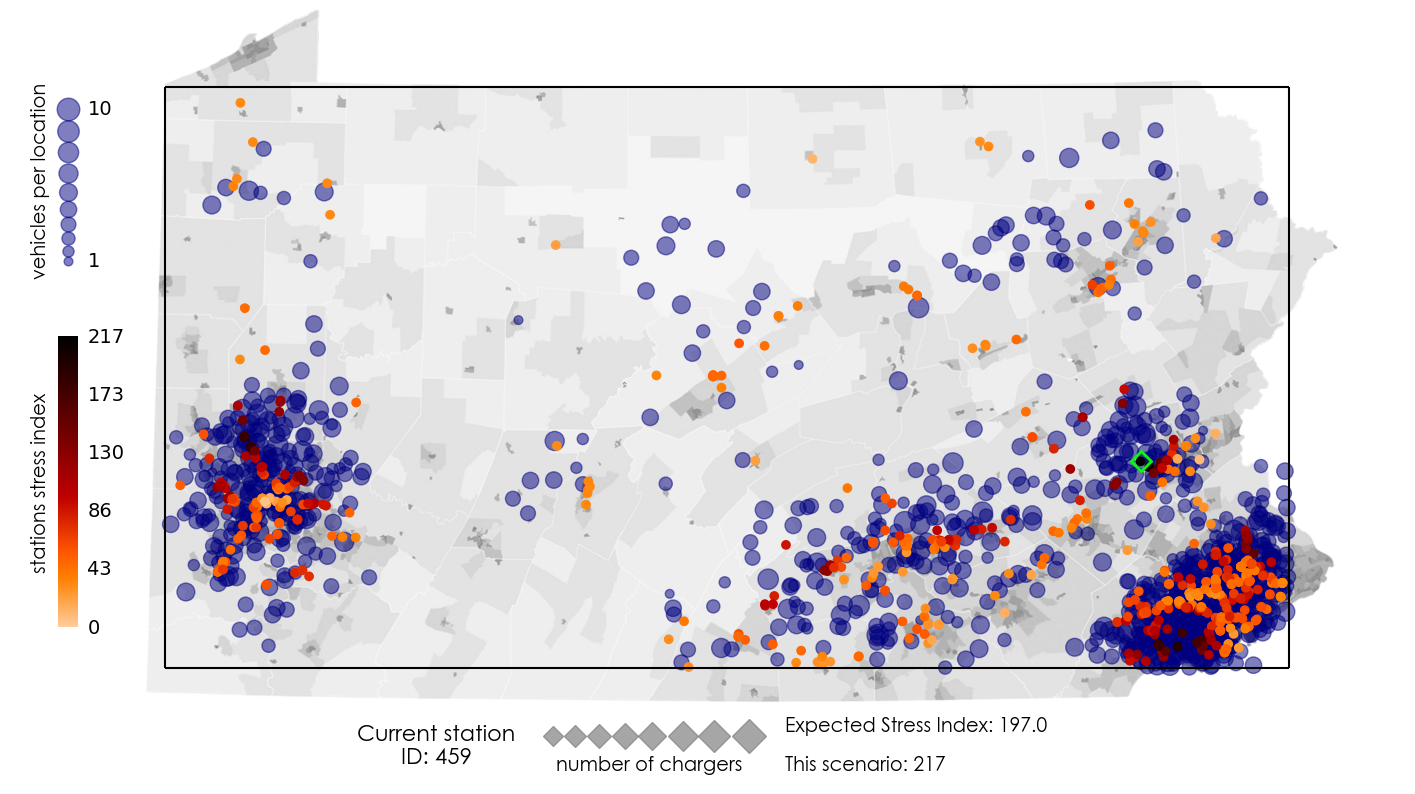

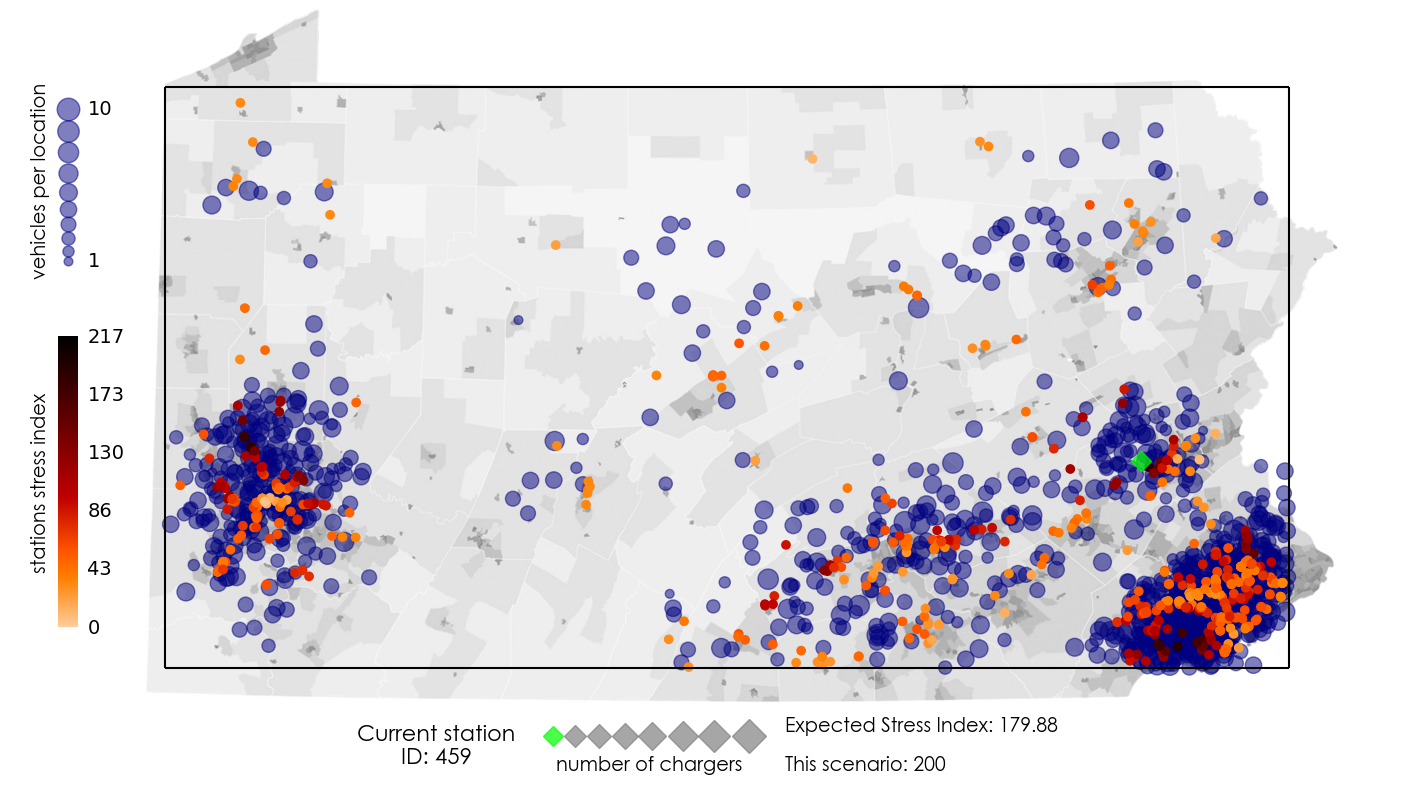

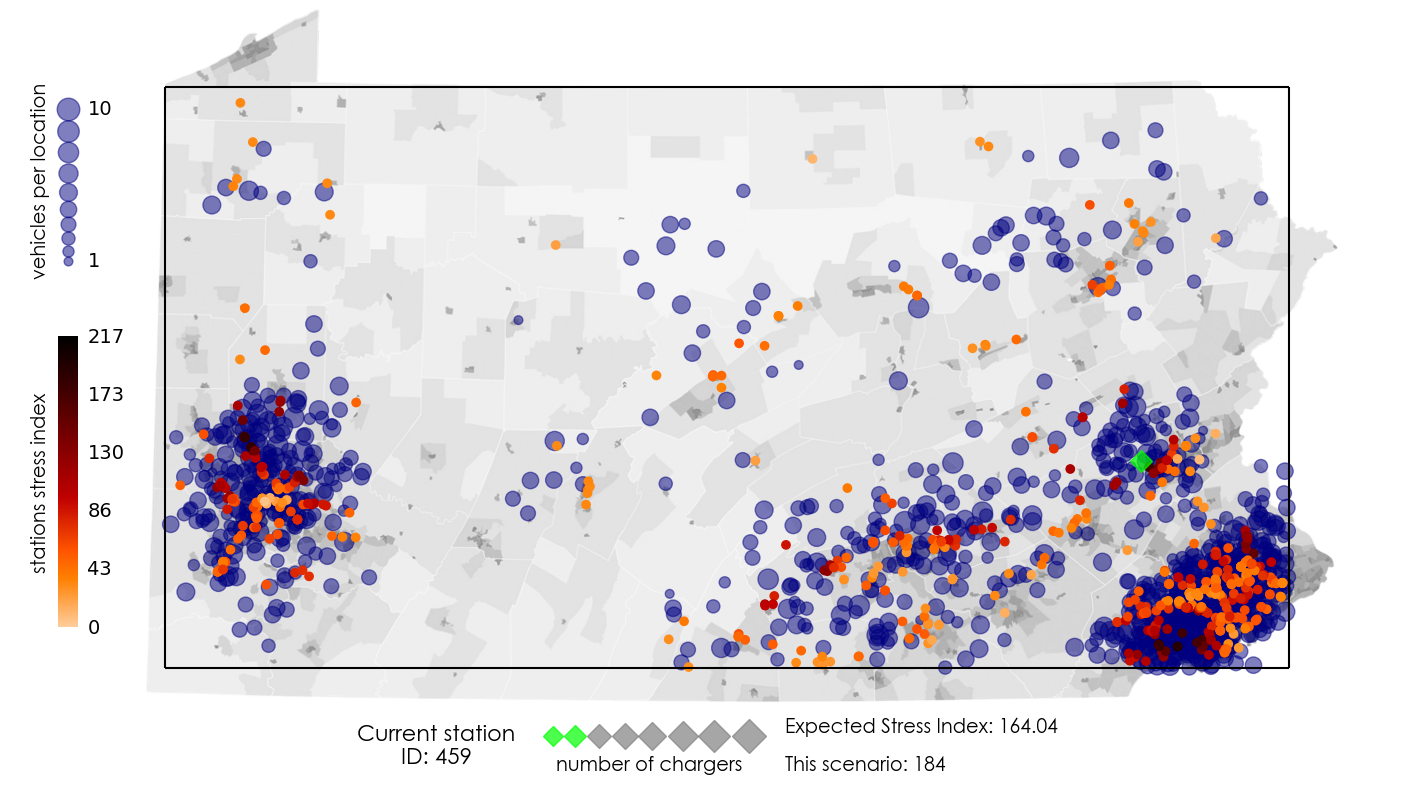

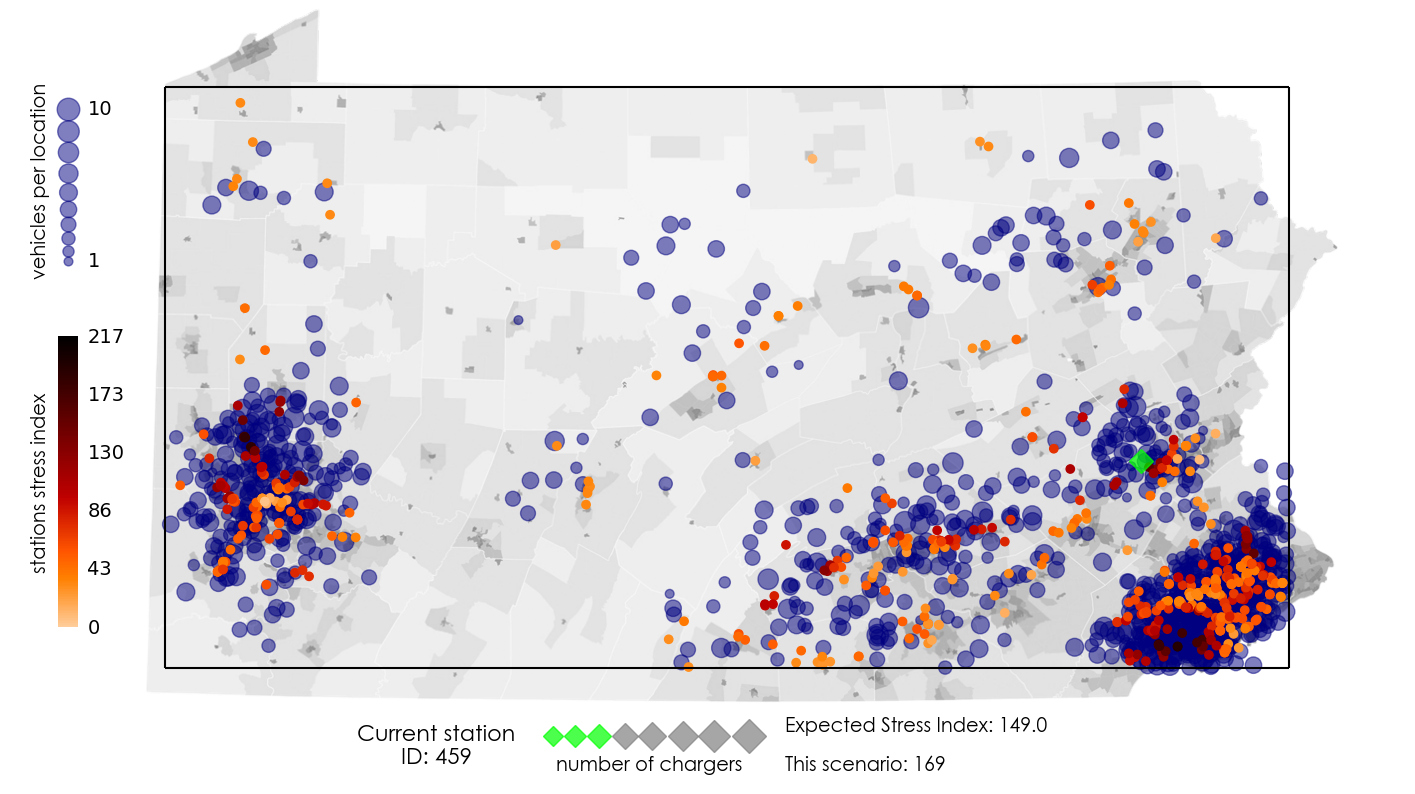

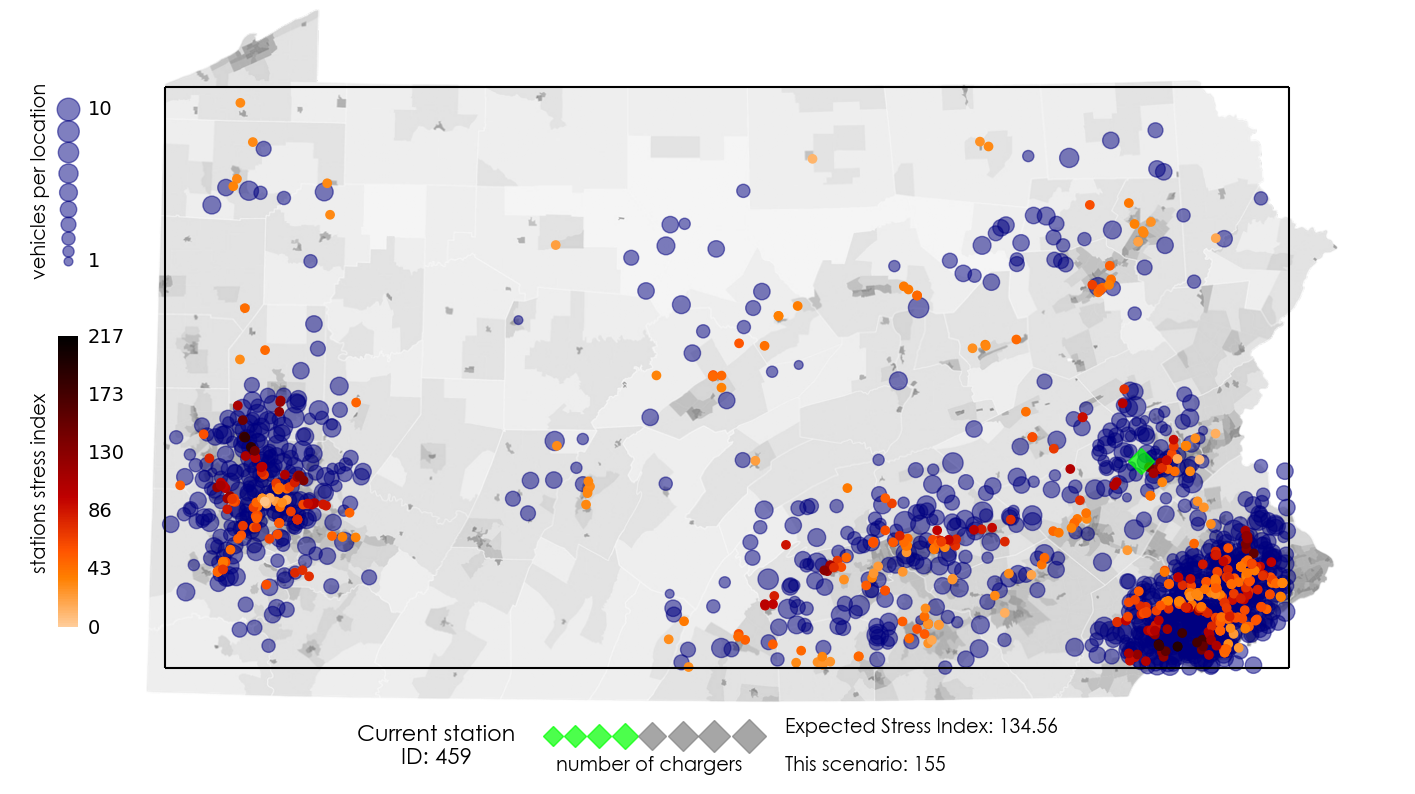

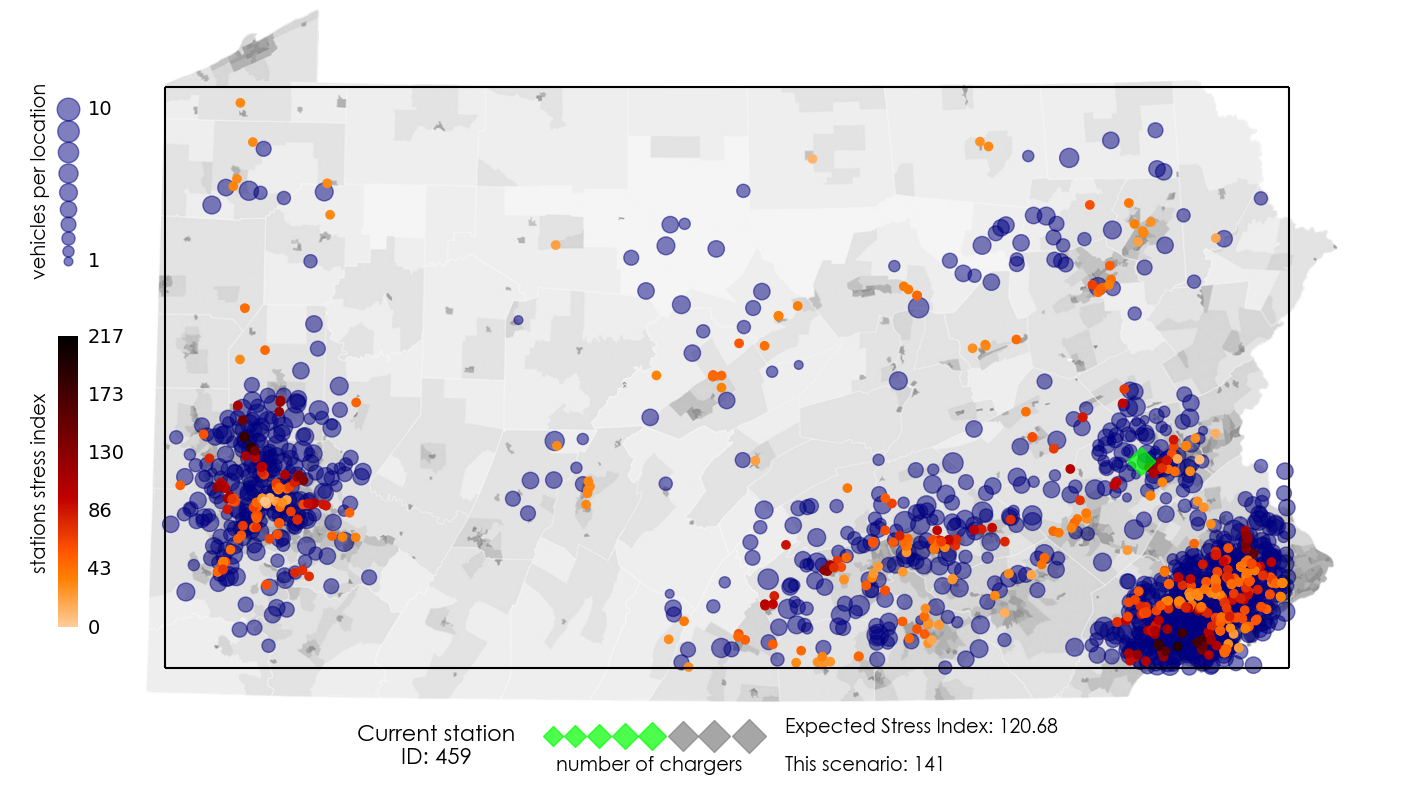

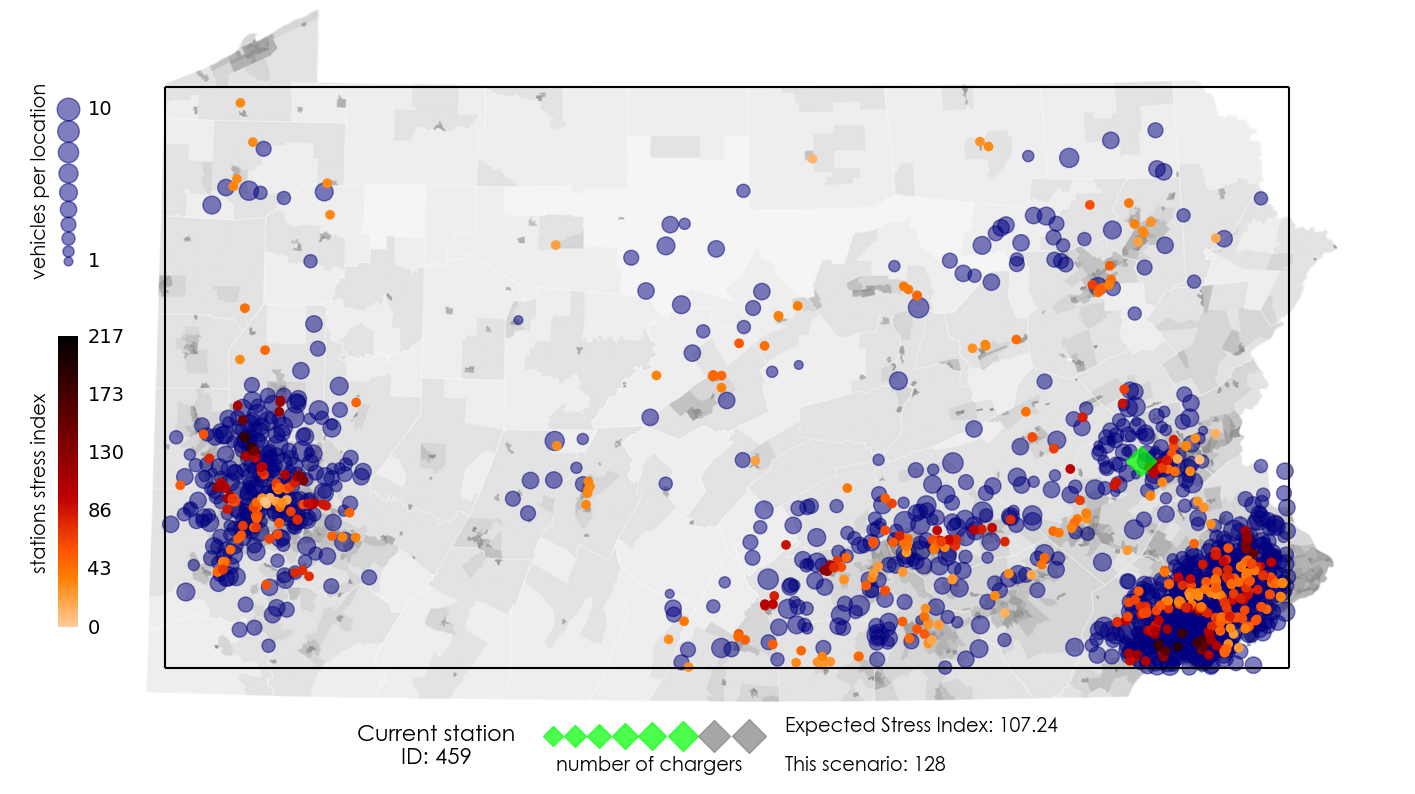

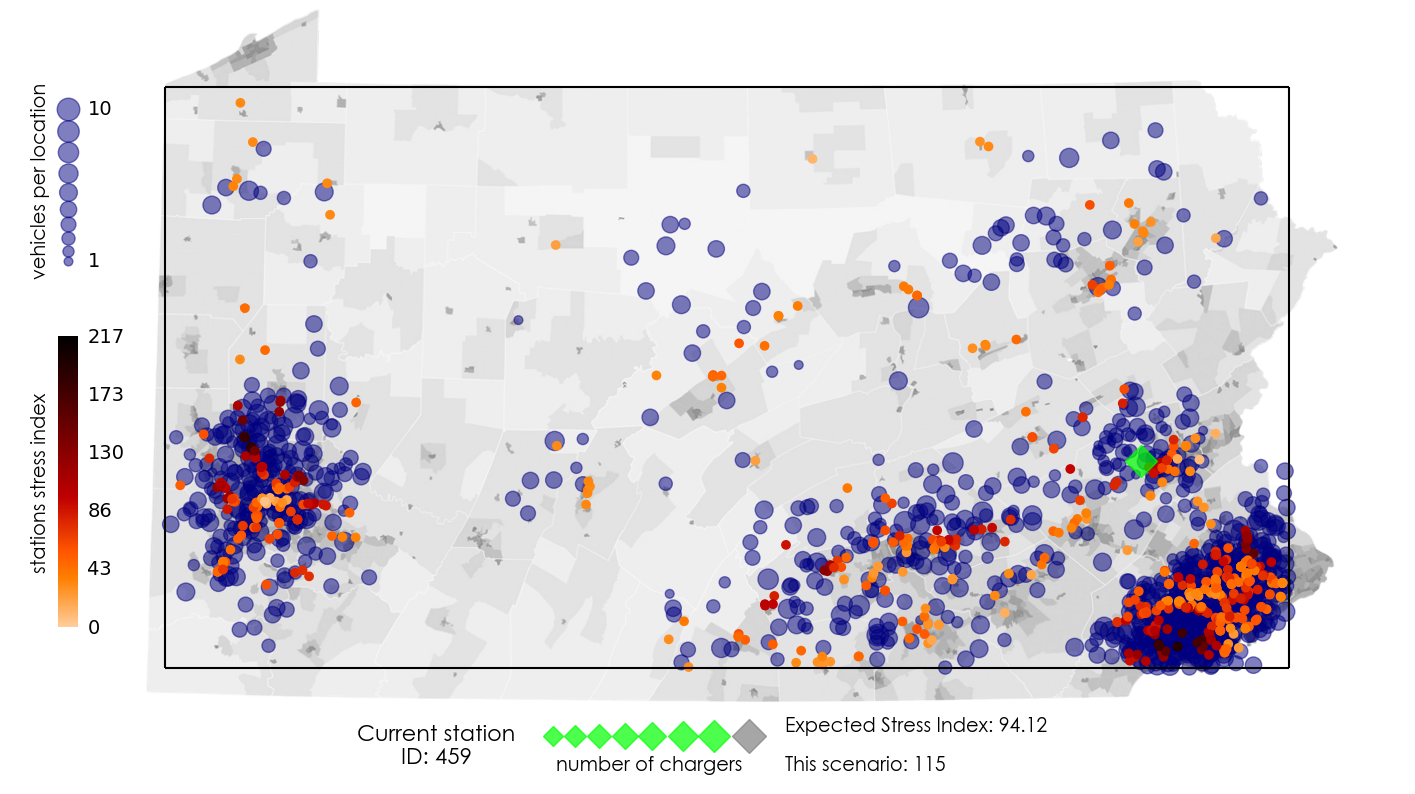

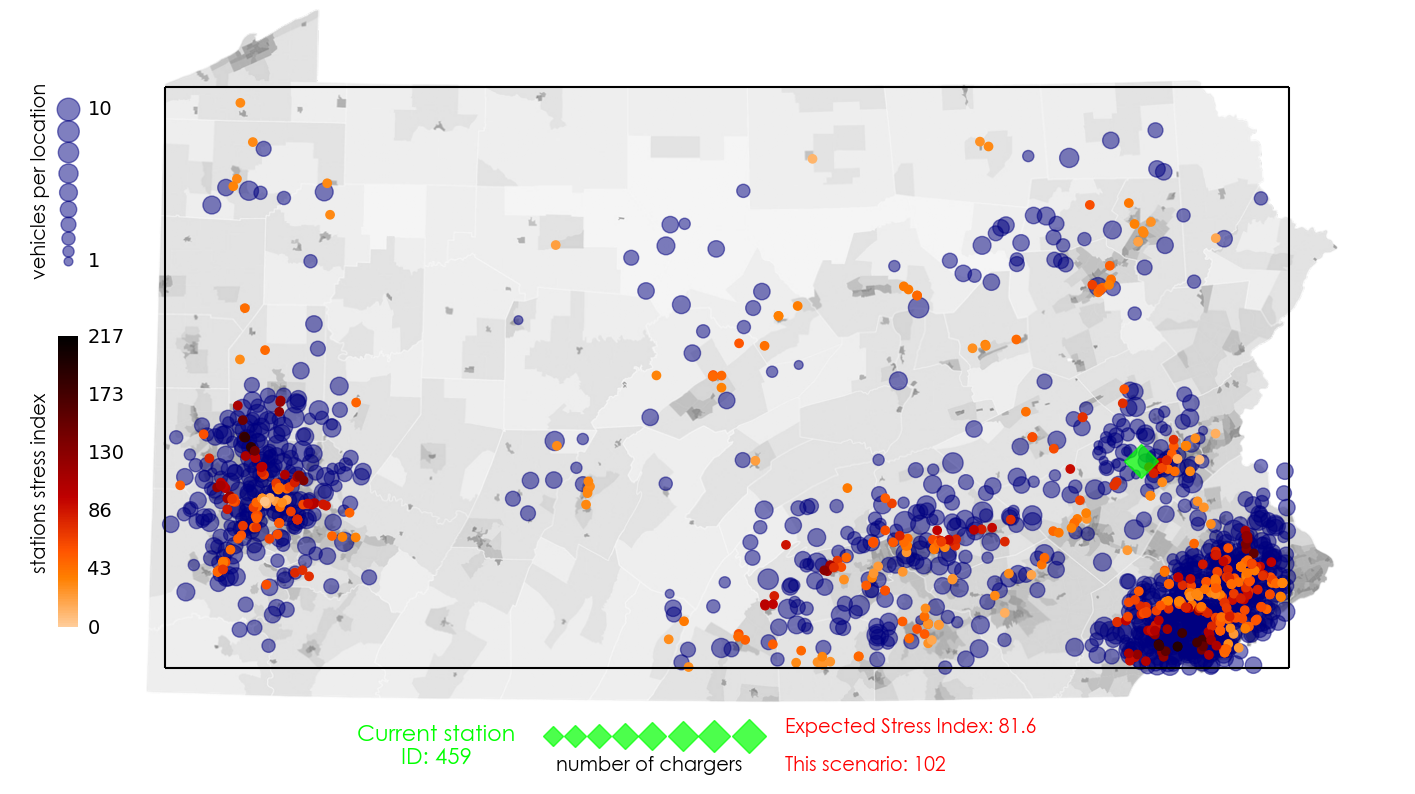

In [5]:
sc = 5
locs = locations[["0","1",f"going {sc}"]]
stress = stress_index.copy()
routes = {scc:results[scc]["routes"].copy() for scc in range(25)}

previous_stations = list()

for ix in range(1,155):
    station = stats_order[ix]
    for ch in range(n[station]+1):
        locs,stress = plot_solution(station=station,chargers=ch,locations = locs, stress_index=stress, routes = routes, prev_stats = previous_stations, sc = sc)
    previous_stations.append(station)
